# Interactive sampler

1. train a sampler
2. user can navigate through the sampling process

initialise notebook and logger:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from eden.util import configure_logging
from IPython.core.display import display
import logging
configure_logging(logging.getLogger(),verbosity=1)



# IF U HUMAN: SET DEBUG FALSE
# enabling automated testing by overwriting this.. :) 
DEBUG=True 
def inputgen():
    for v in ['1','exit','19','55','exit']:
        yield v
if DEBUG:
    ig=inputgen()
    raw_input=ig.next


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ikea/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ikea/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## train sampler

In [2]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden_extra.converter.graph.gspan import gspan_to_eden
import itertools
import graphlearn.utils.interactive as interactive

GRAPHPATH=  '../../toolsdata/bursi.pos.gspan'
    
    

def get_sampler():
    # get training graphs
    training_graphs = gspan_to_eden(GRAPHPATH )
    training_size=200
    training_graphs = itertools.islice(training_graphs,training_size)

    #create a sampler and fit on training
    sampler=gl.Sampler(decomposer=interactive.mywrap(),
                      
                          core_choice_byfrequency = False,
    core_choice_byscore = False,
    size_constrained_core_choice = -1,
    size_diff_core_filter=-1,
    similarity = -1,
    n_samples = None,
    proposal_probability = False,
    batch_size = 10,
   
    quick_skip_orig_cip = False,
    select_cip_max_tries = 20,
    burnin = 0,

    include_seed = False,
    keep_duplicates = False
                      
                      )
    #sampler.transform([],).next()
    
    sampler.fit(training_graphs)
    #prepare interactive module
    interactive.setparameters(sampler)
    return sampler
sampler=get_sampler()
print 'OK'

OK
CPU times: user 4.08 s, sys: 372 ms, total: 4.45 s
Wall time: 8.28 s


## help the sampler to decide which generated graph to accept

You will see a current graph in the middle and 8 graphs to choose from. 

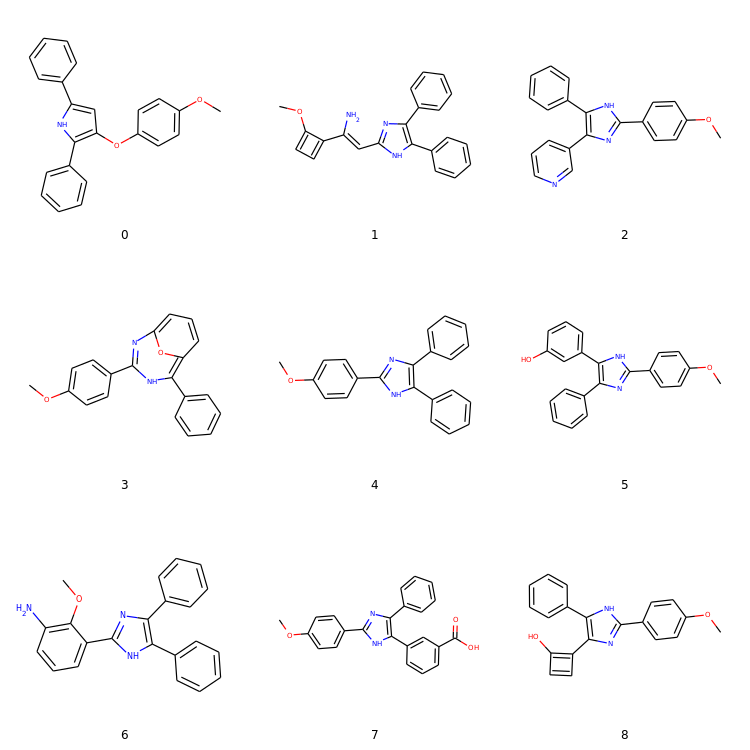

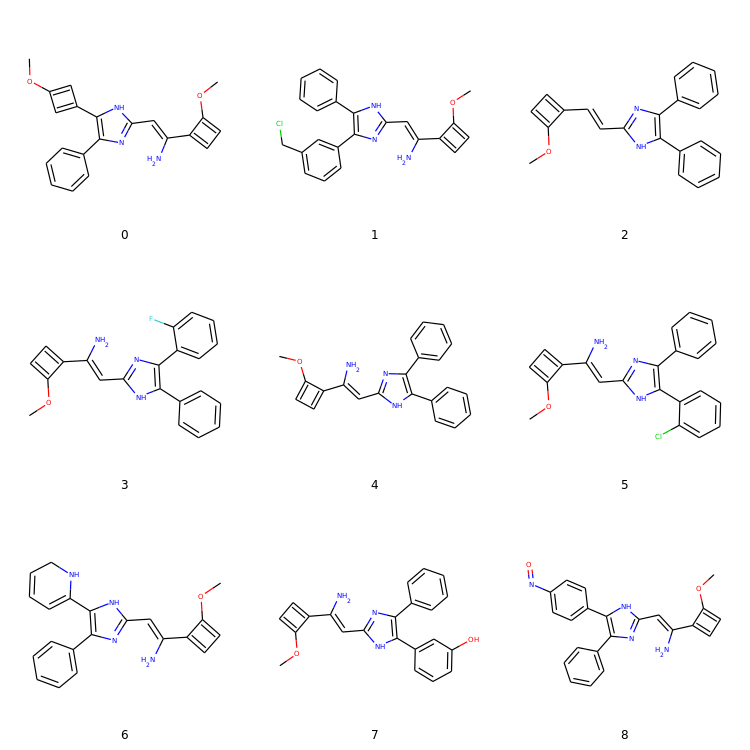

In [3]:
import networkx as nx
from eden_chem.display.rdkitutils import nx_to_image as gmdraw
import eden

# choose a start graph
gr = gspan_to_eden( GRAPHPATH)
CURRENT = sampler._sample_init(gr.next())

while True:
    # generate 8 graphs
    graphmanz=interactive.easy_get_new_graphs(CURRENT,sampler)
    # put old one in middle (of the plot)

    g=[grman.base_graph() for grman in graphmanz ]
    g=g[:4]+[CURRENT.base_graph()]+g[4:]
    # draw them 
    #draw.graphlearn(g,n_graphs_per_line=3, node_size=400,contract=True,node_border=0.5)
   
    g2=map(eden.graph._revert_edge_to_vertex_transform,g)
    image=gmdraw(g2,n_graphs_per_line=3)
    display(image)
    
    #pick a graph that is the new CURRENT
    x=raw_input()
    if x=='exit':
        break
    CURRENT=graphmanz[int(x)]
    CURRENT.real_clean()

## EXPERT MODE

First choose a node in the graph that you want to change. 
Then select from all available options.


In [4]:
import rdkit
rdkit.__version__

'2015.03.1'

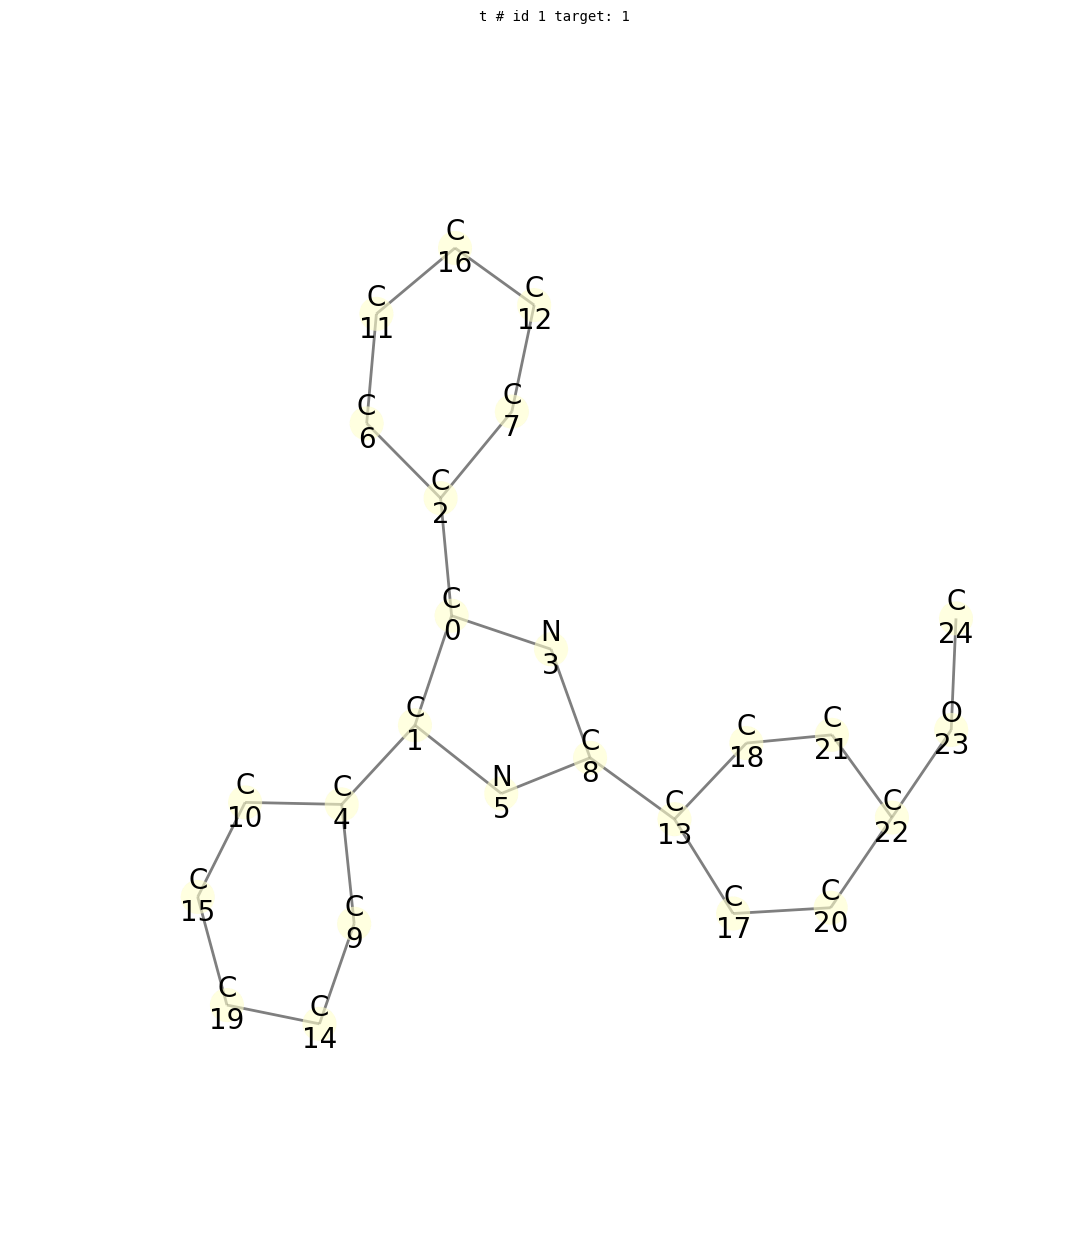

choose a node


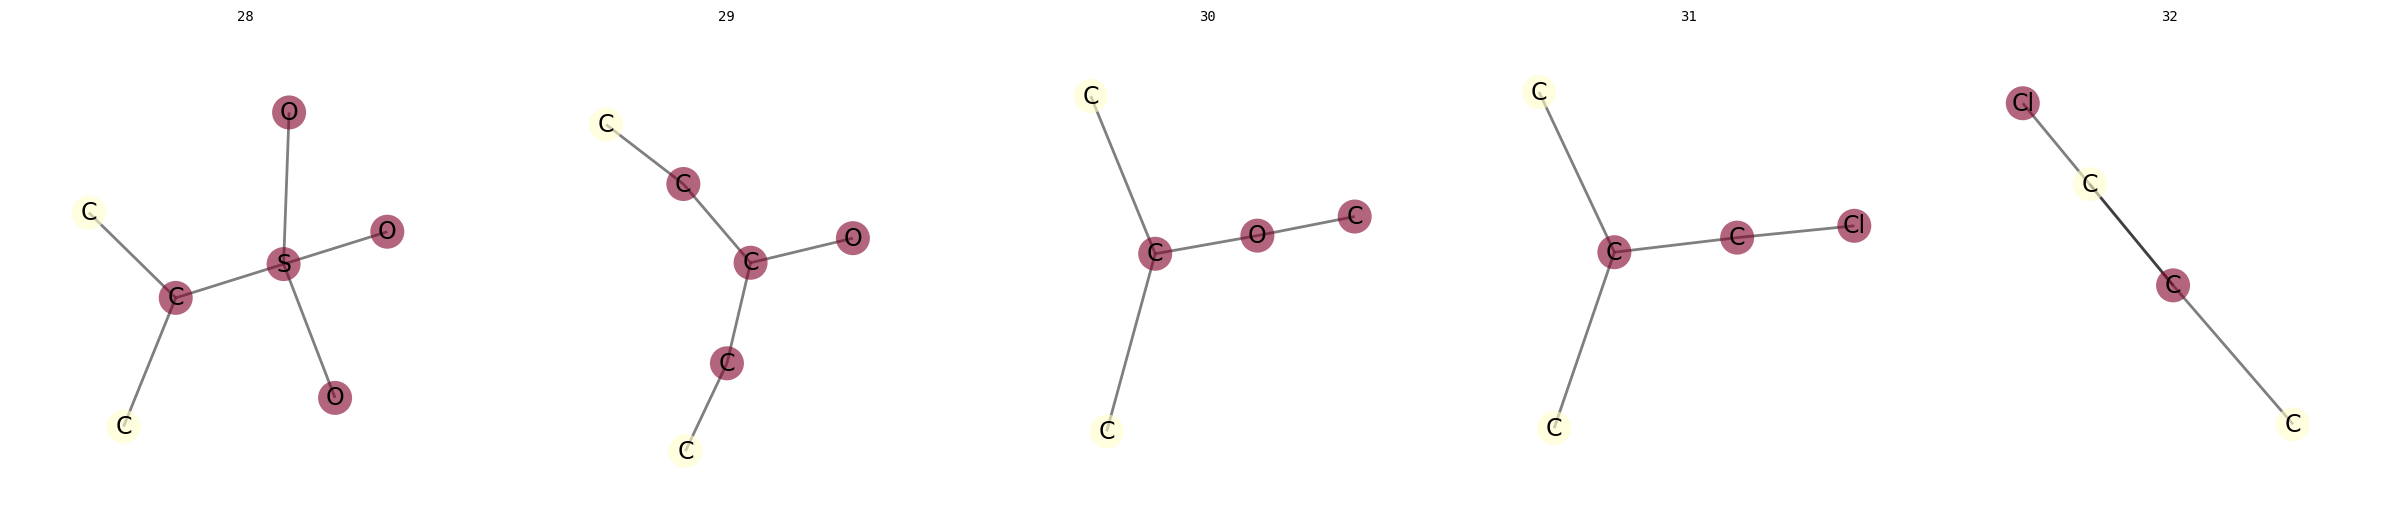

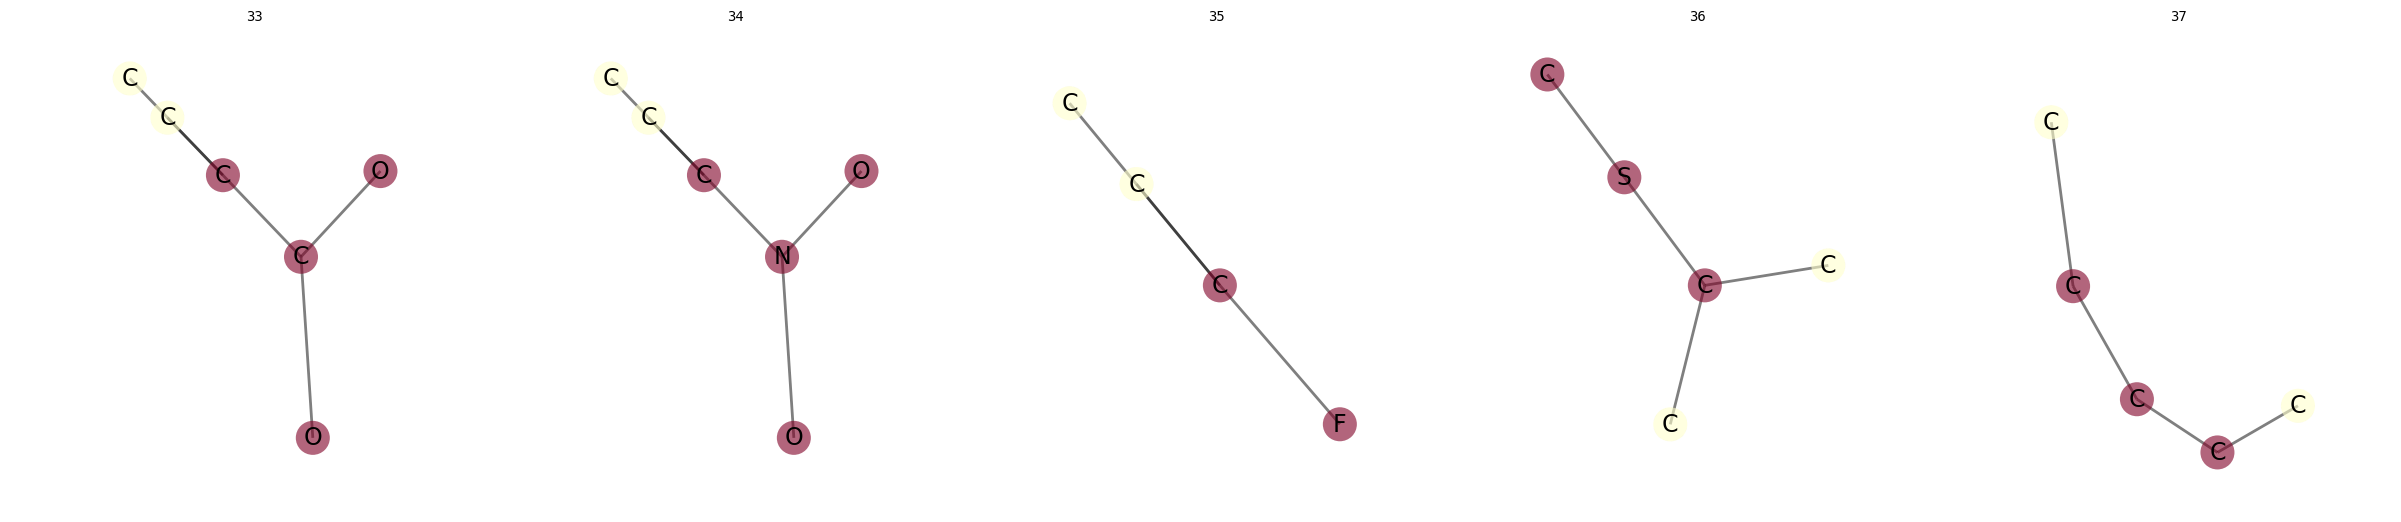

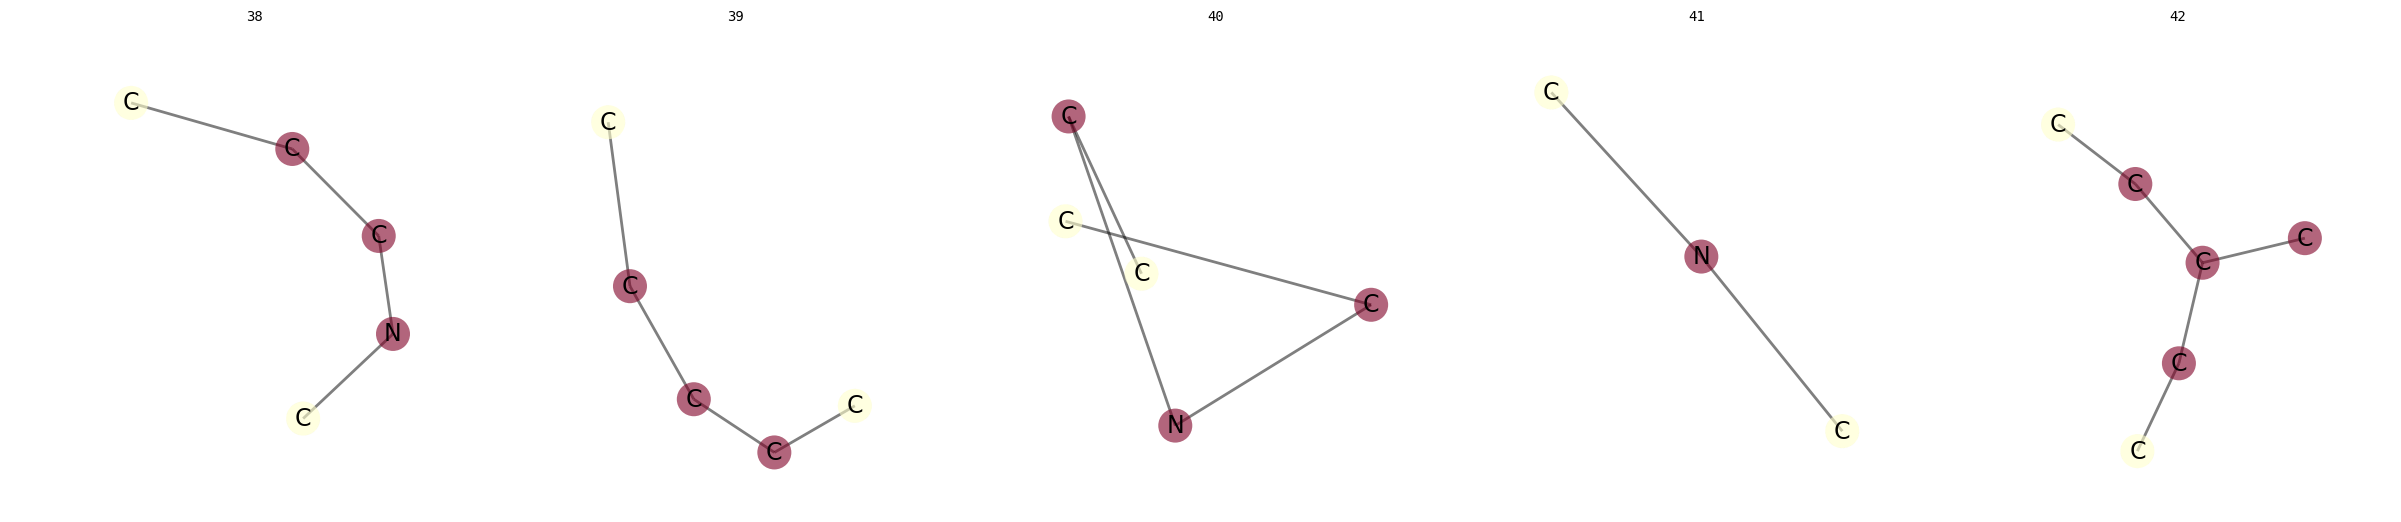

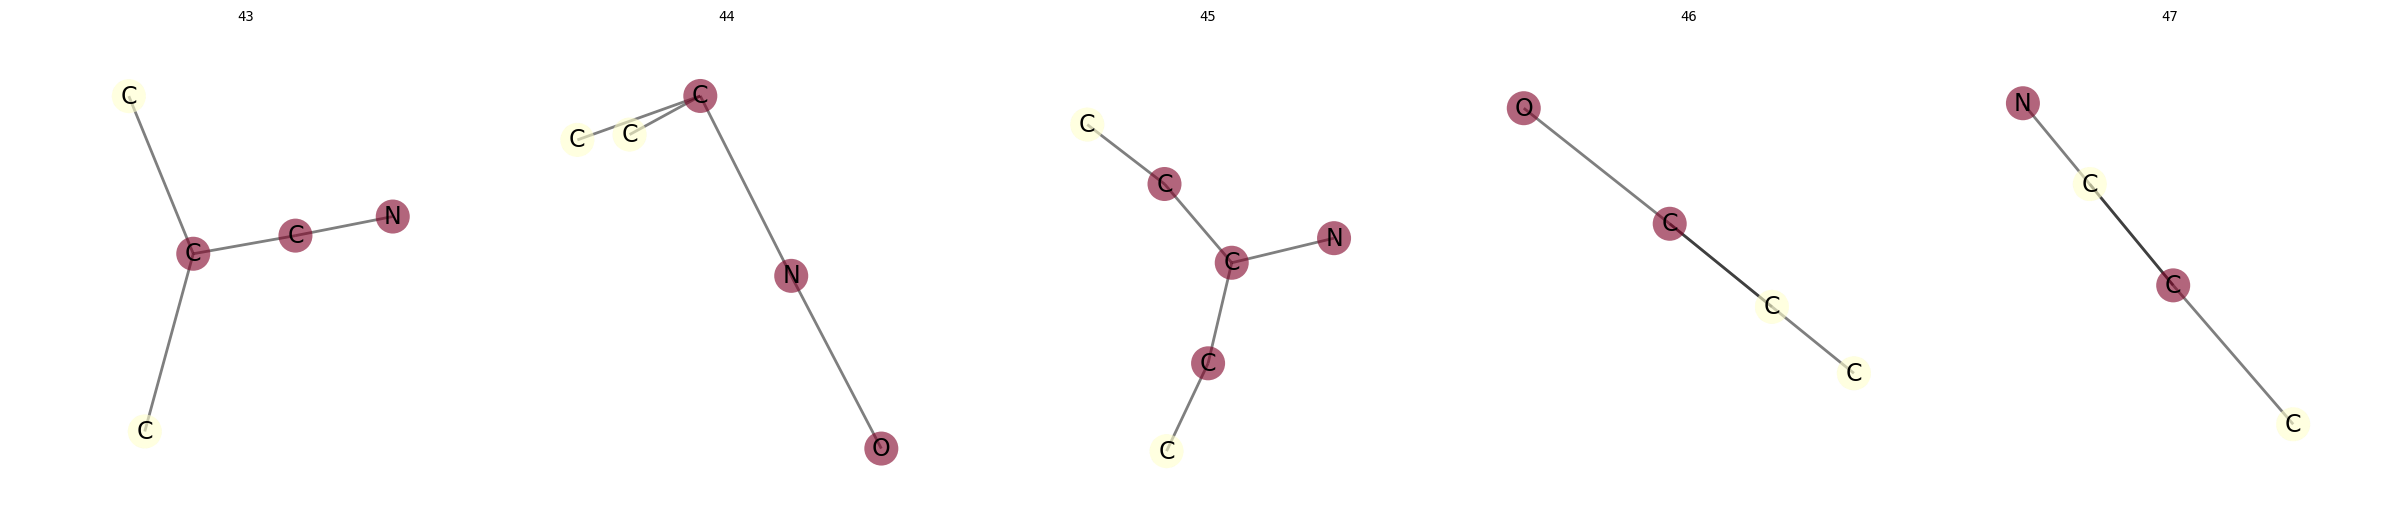

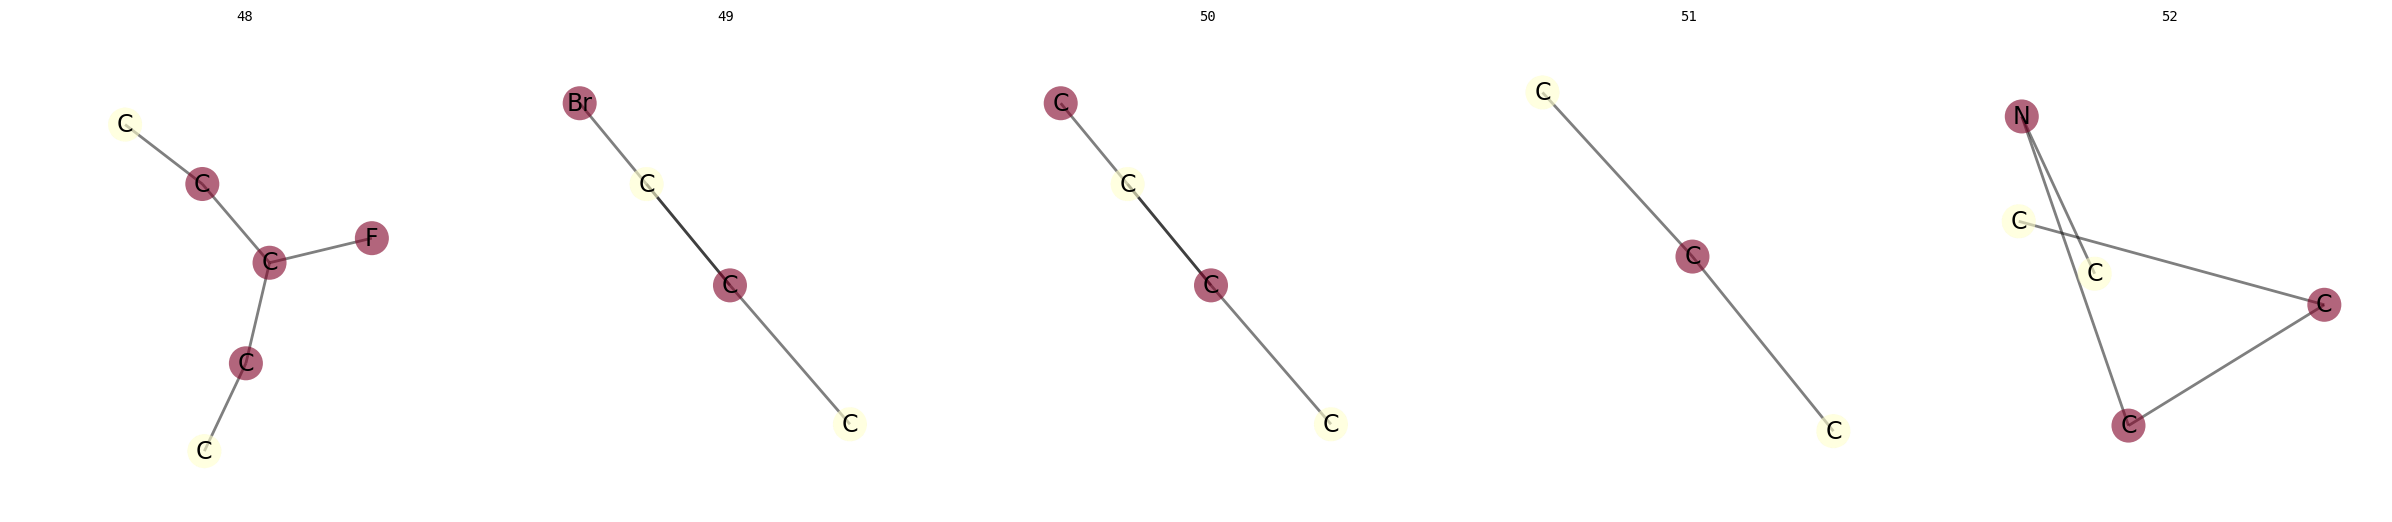

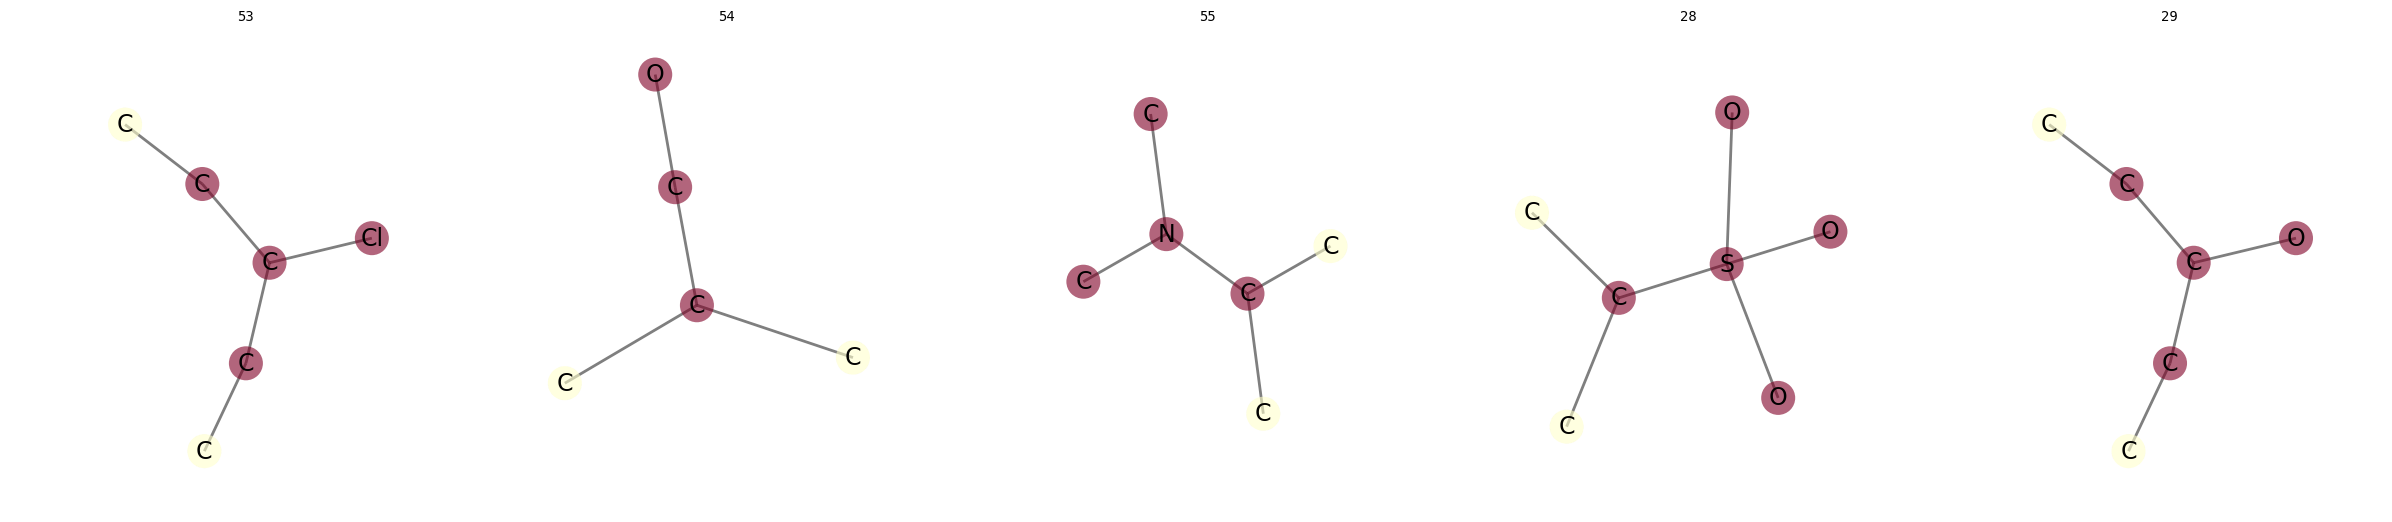

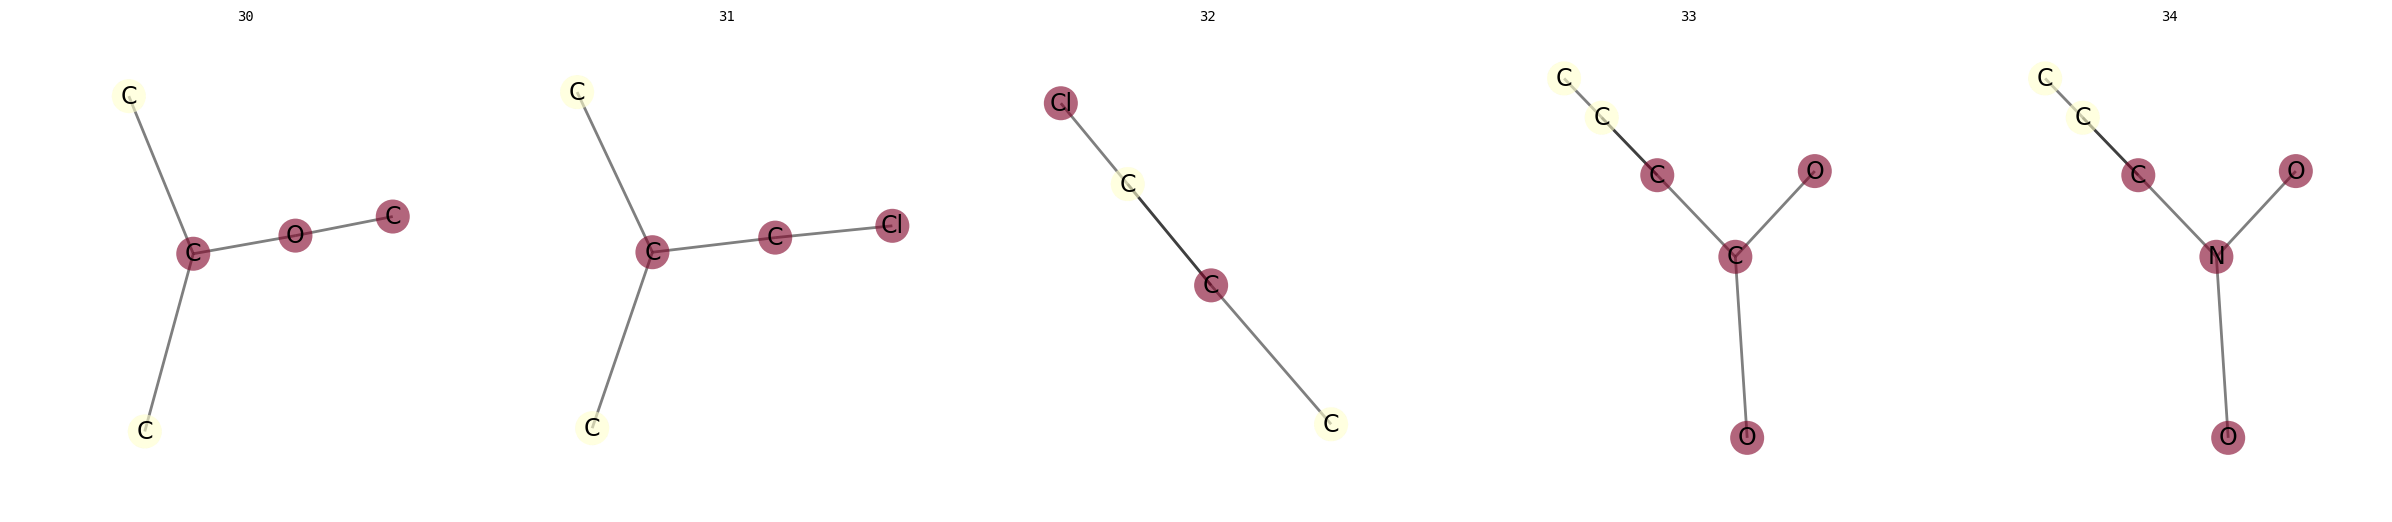

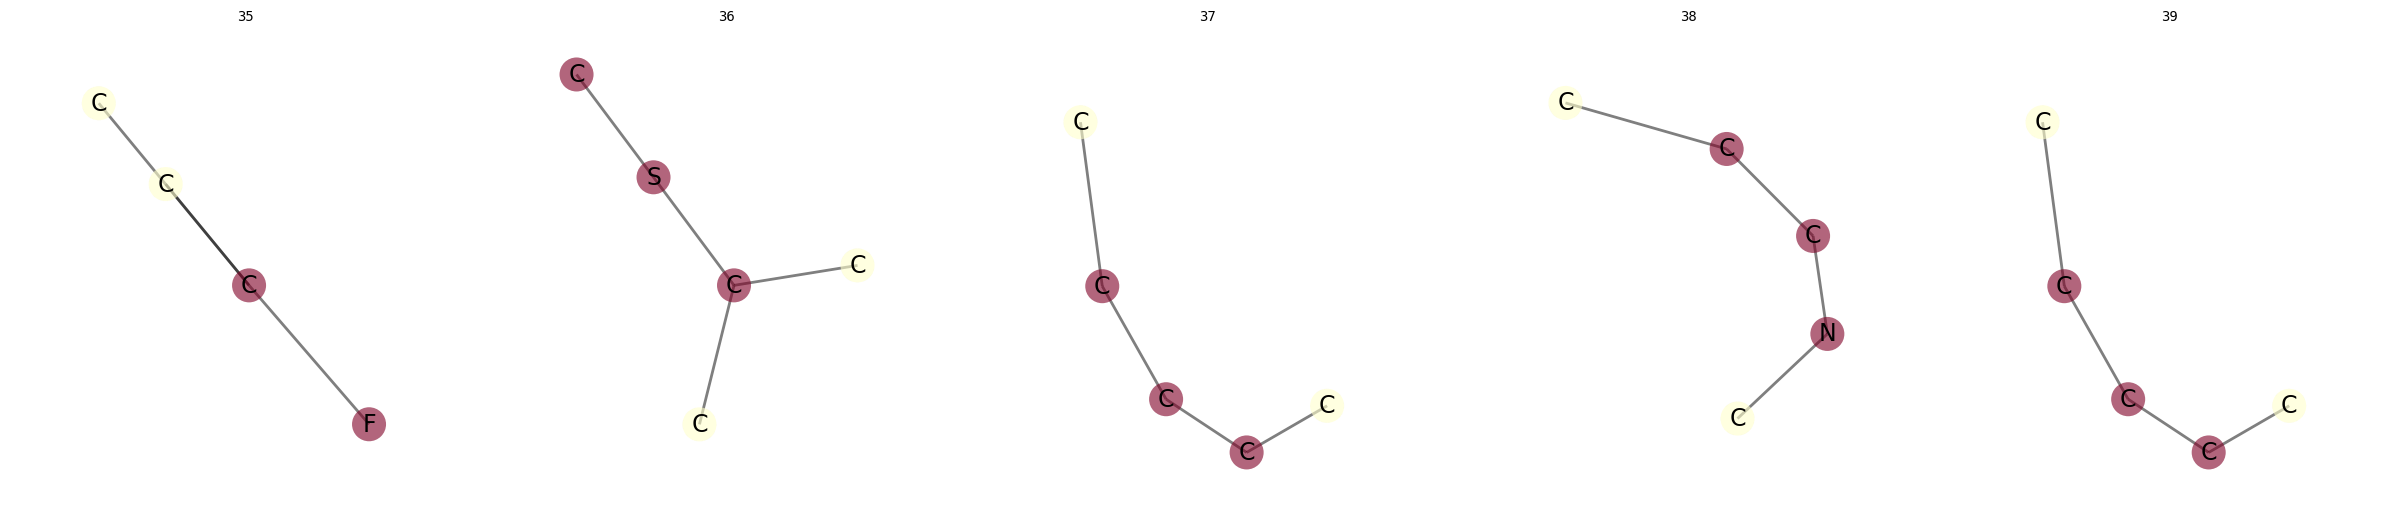

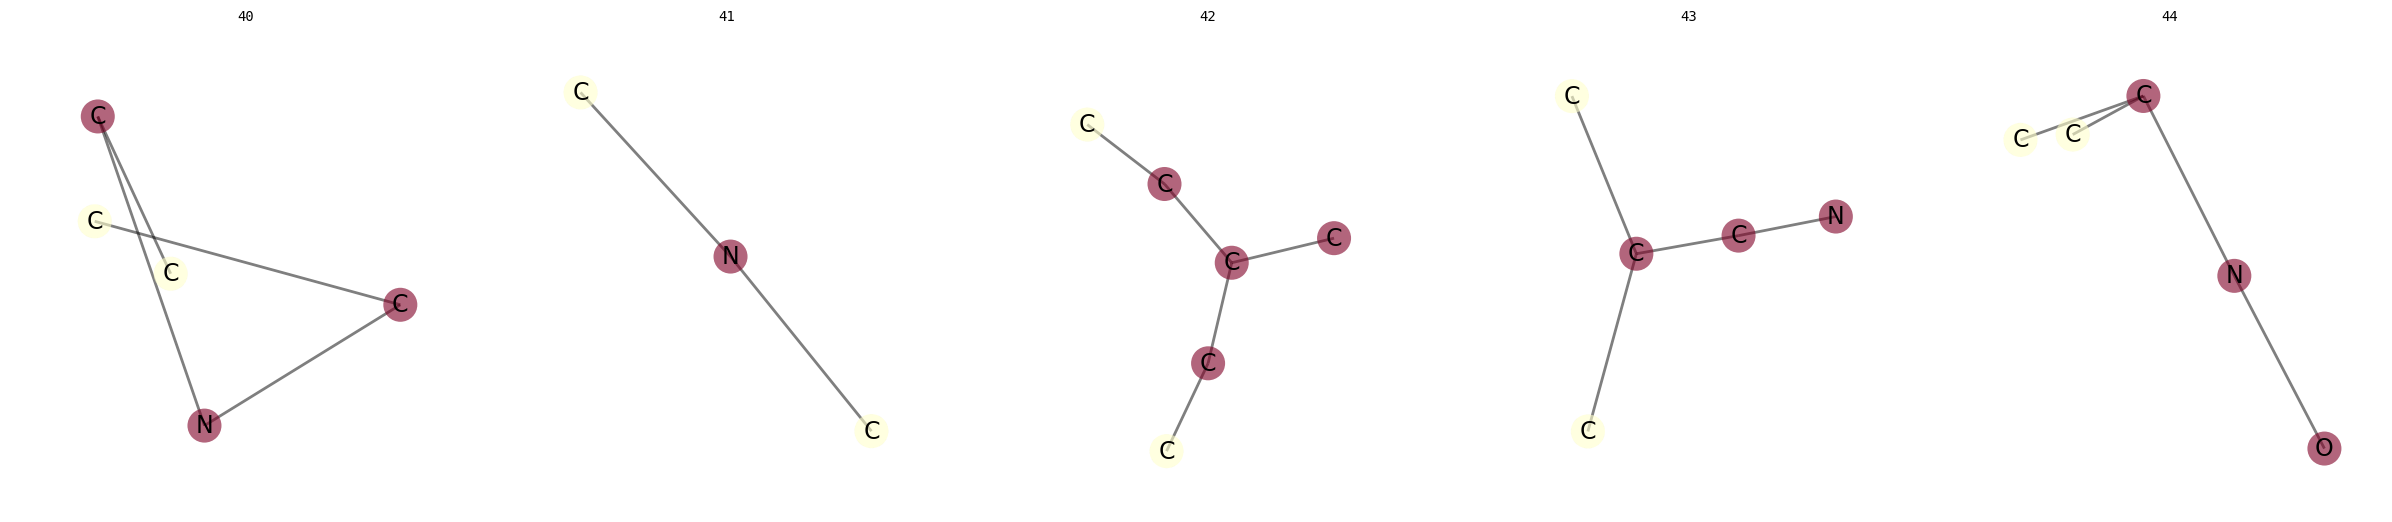

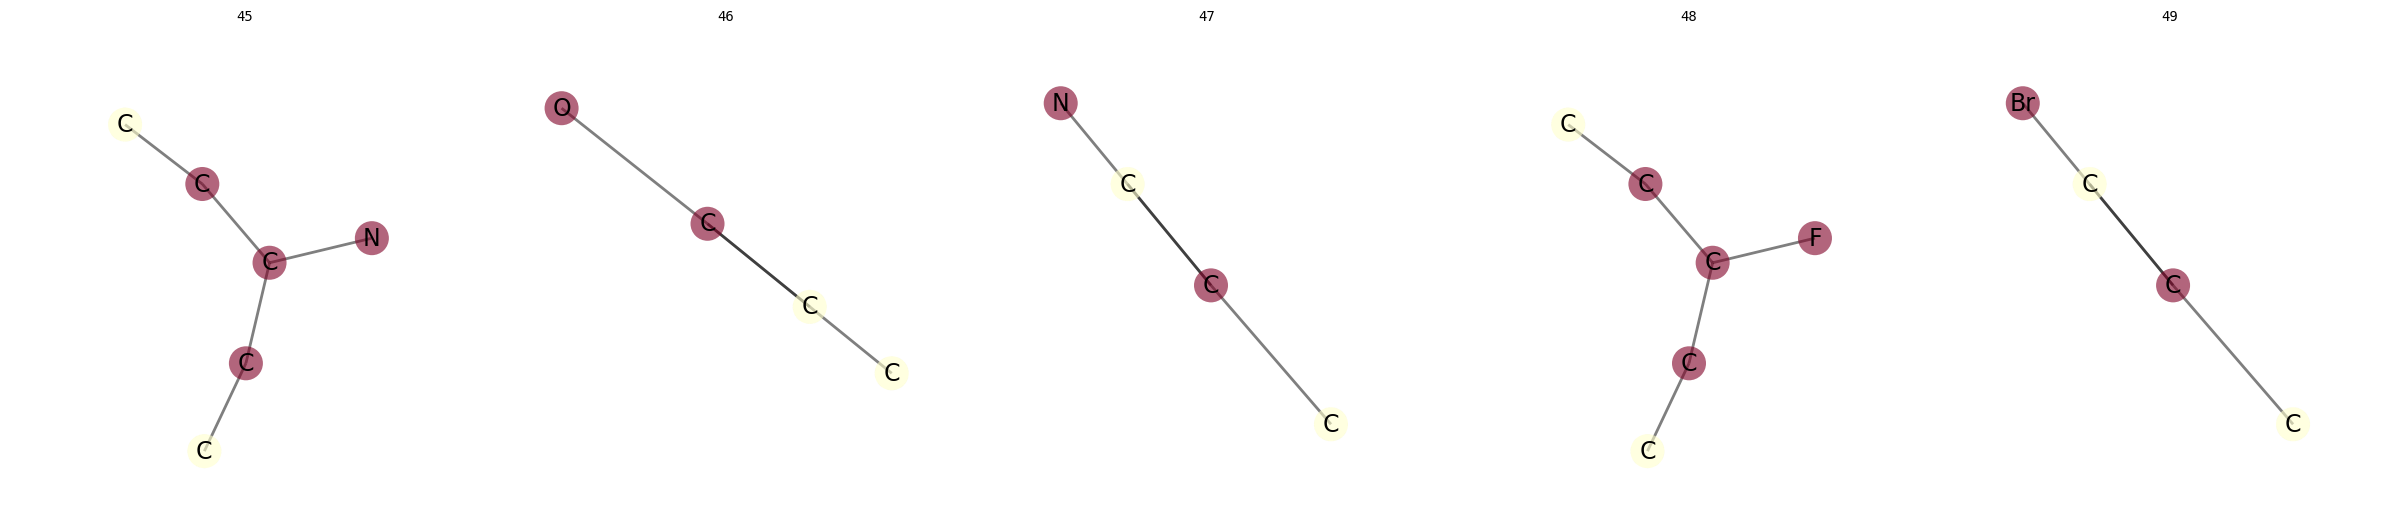

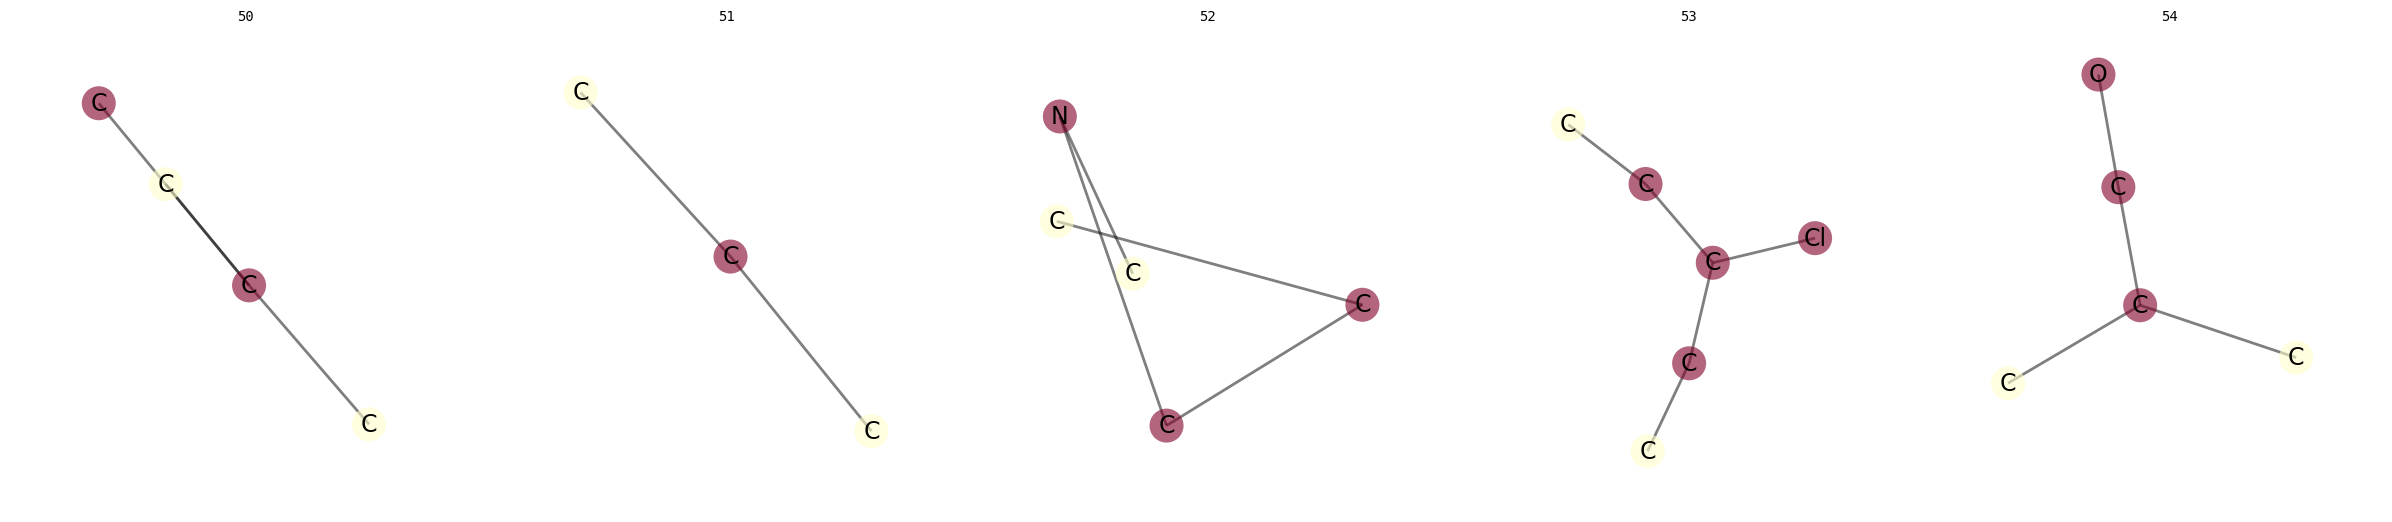

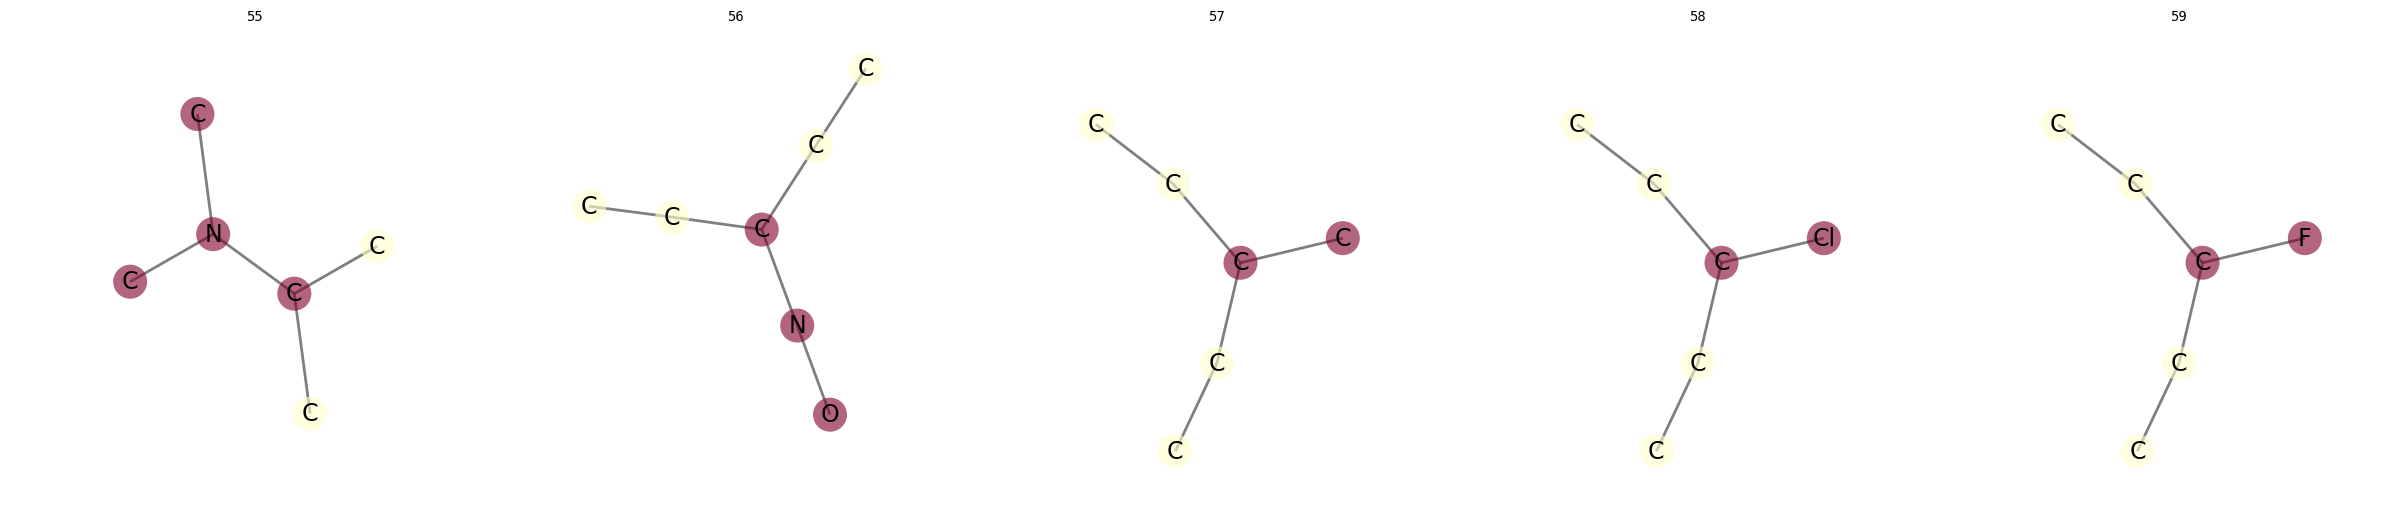

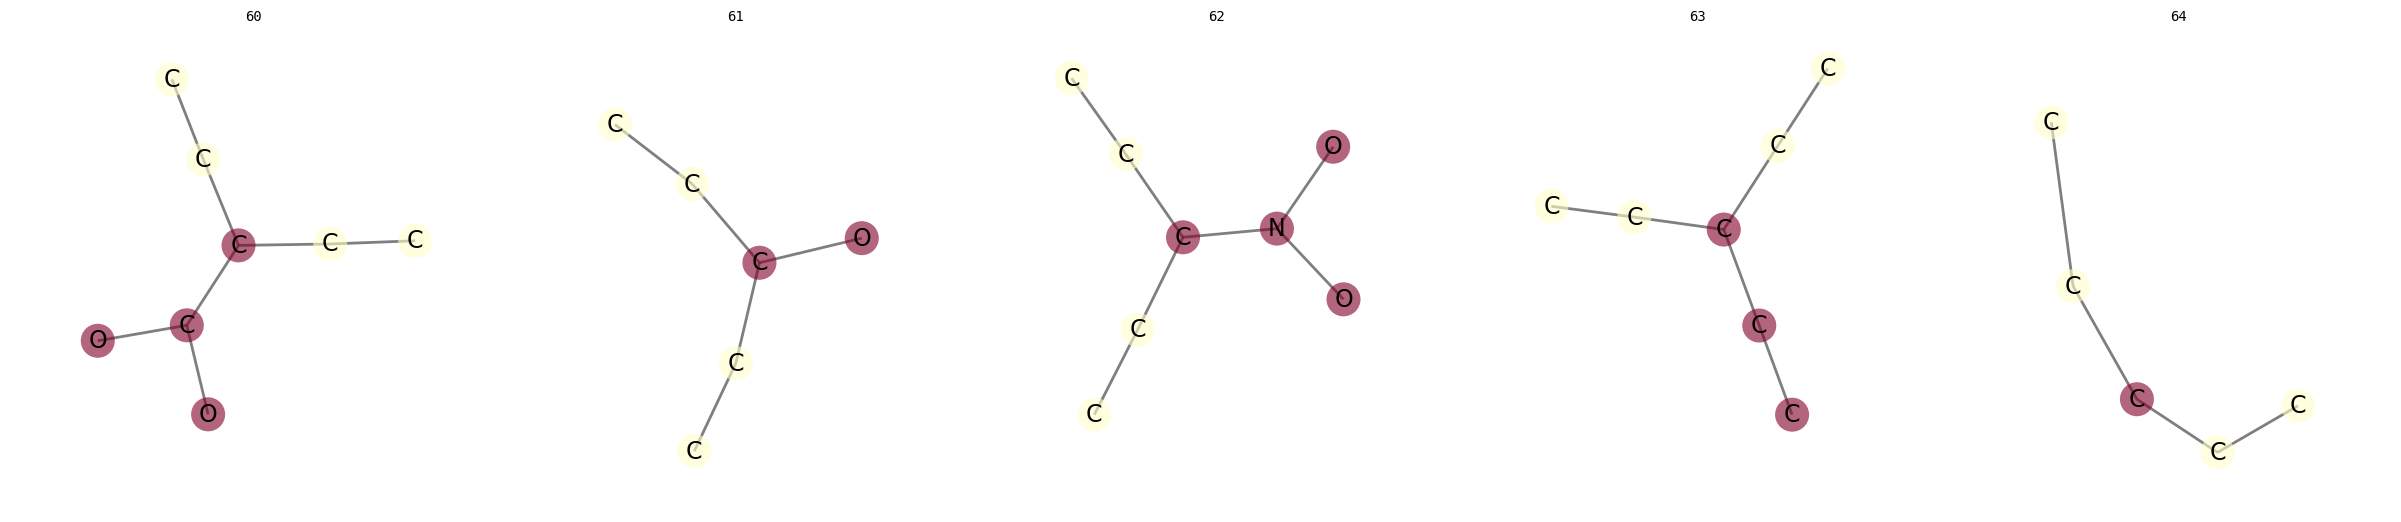

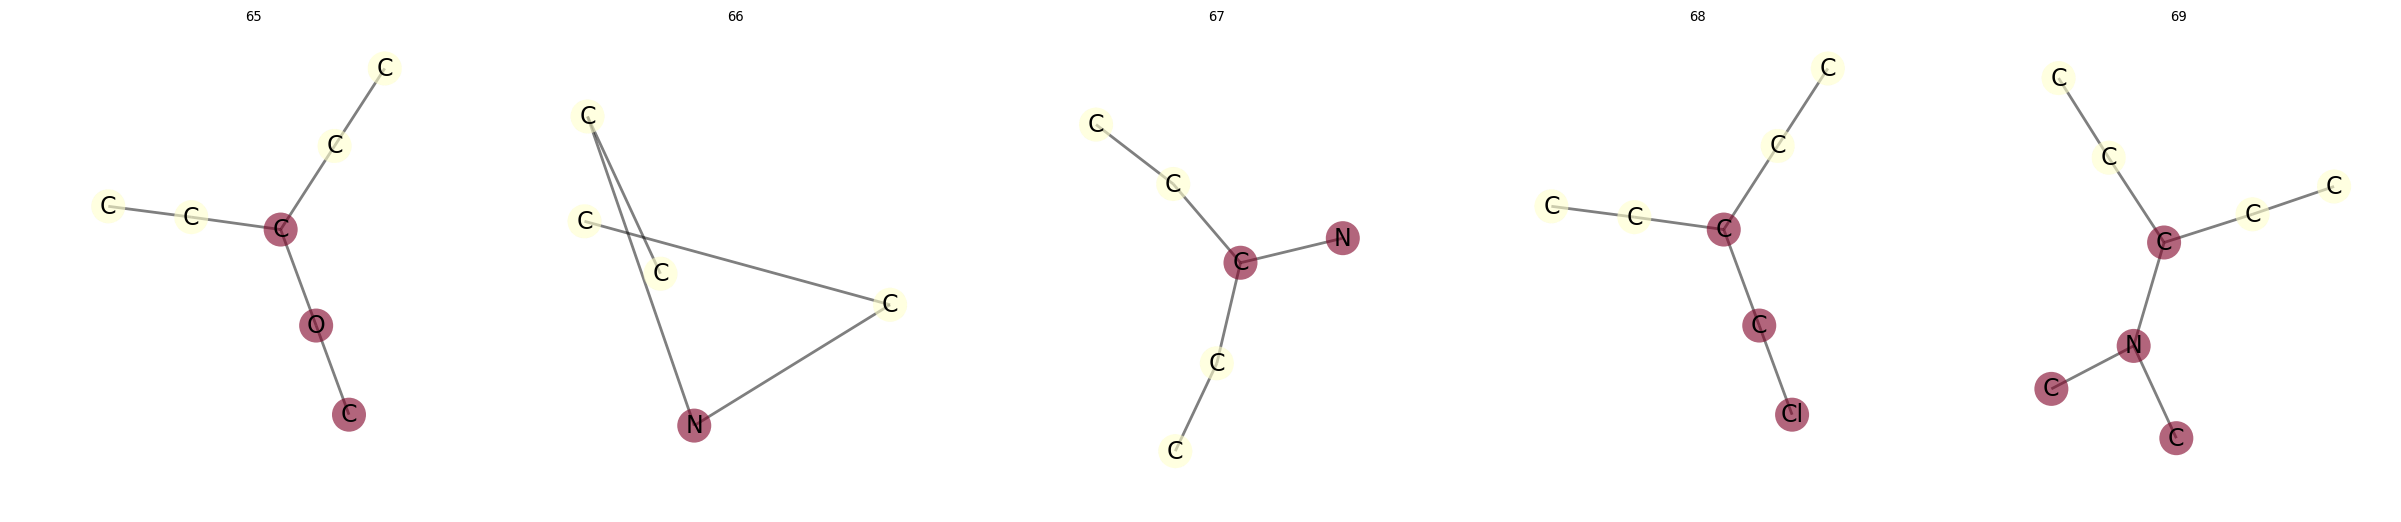

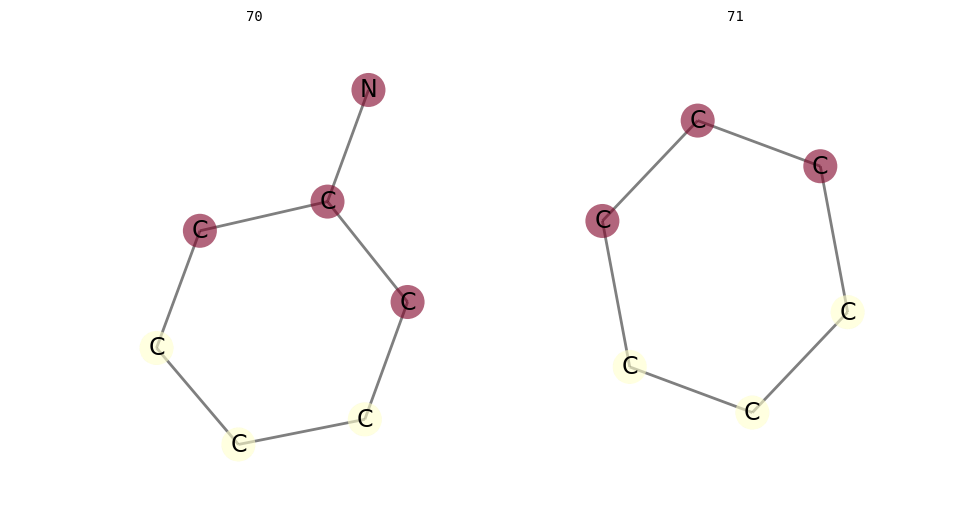

choose a CIP; red nodes will be added


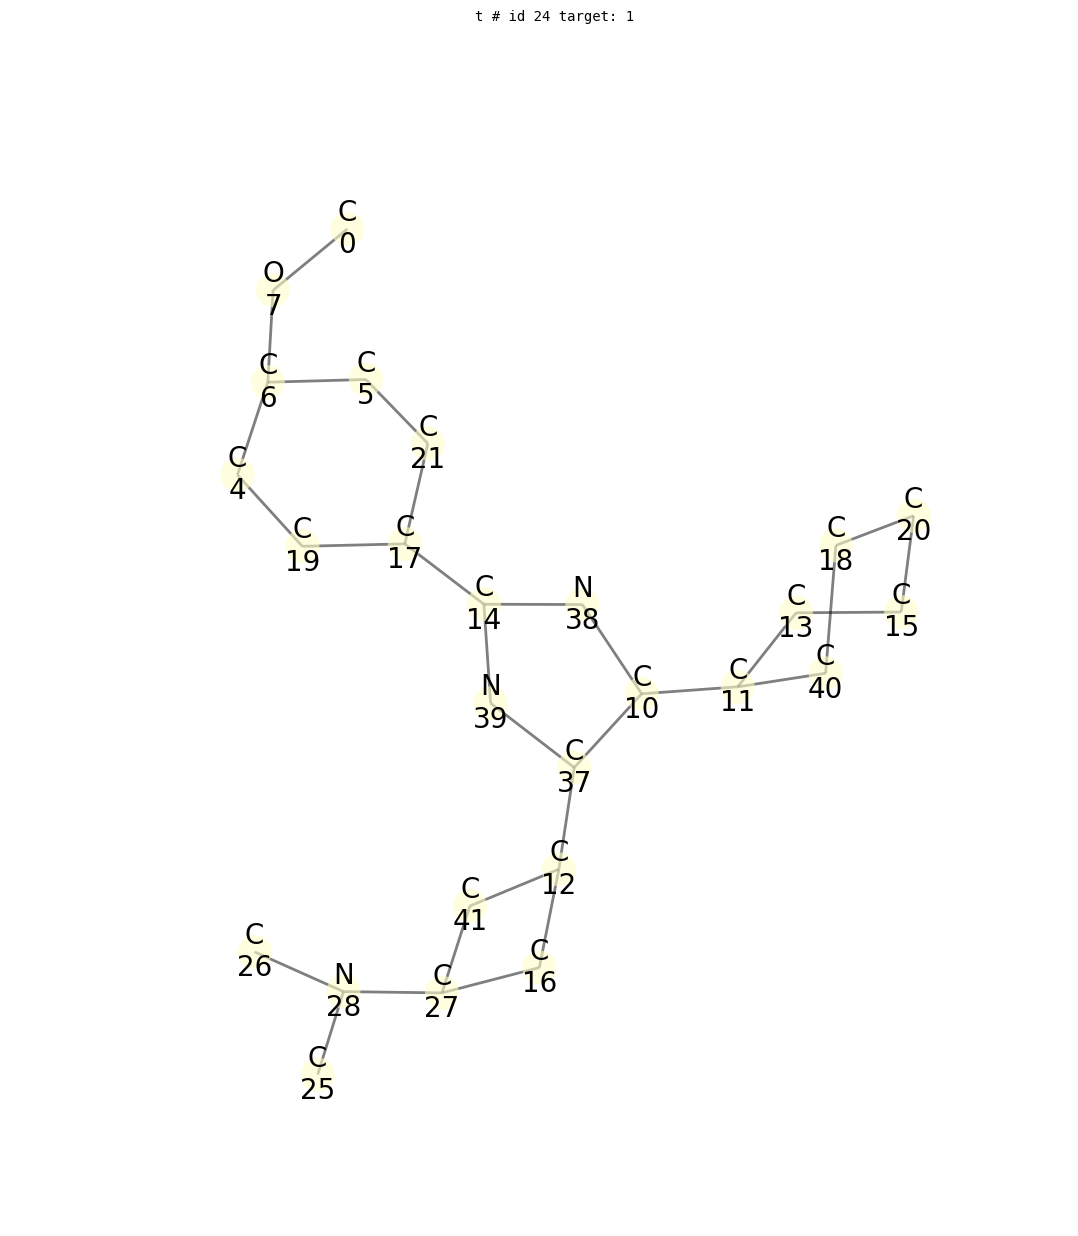

choose a node


In [5]:
import networkx as nx
from graphlearn.utils import draw

sampler=get_sampler()
# initialize and provide a graph to work on
args=interactive.getargz(sampler)
gr = gspan_to_eden( GRAPHPATH )
CURRENT = sampler._sample_init(gr.next())


while True: 
    # draw graph and choose node
    draw.graphlearn(CURRENT.base_graph(),secondary_vertex_label='id',size=15,contract=True, font_size=20)
    print "choose a node"
    valu=raw_input()
    if valu=='exit':
        break
    node_id=int(valu)
    
    # draw new cips and choose one
    cips=interactive.get_cips(CURRENT,sampler,node_id,args)
    if len(cips)==0:
        print 'no replacements found,try again'
        continue
    cip_graphs=[ c.graph for c in cips ]
    draw.graphlearn(cip_graphs, font_size=17,contract=True,title_key='info')
    print "choose a CIP; red nodes will be added"
    valu=raw_input()
    if valu=='exit':
        break
    cip_id=int(valu)
    
    #replace and clean
    gr=CURRENT.core_substitution( cips[cip_id].orig, cip_graphs[cip_id])
    CURRENT=sampler.decomposer.make_new_decomposer(sampler.graph_transformer.re_transform_single(gr))
    CURRENT.real_clean()

In [6]:
!which python

/usr/bin/python
